# PySpark - Pandas UDF. Машинное обучение
`(применение через .applyInPandas)`  

Рассматривается **PIEPLINE** обучения модели средствами Spark pandas_udf на примере DataSet **Titanic:**   
https://www.openml.org/d42438
```python
from sklearn.datasets import fetch_openml

titanic_data = fetch_openml('titanic', version=1, as_frame=True)
```

**Задача:** Бинарная классификация (**Модель**:Логистическая регрессия)

**Dataset:** Titanic (tran: train.csv, test: test.csv)
  
**Целевая переменная:** "Survived" (1 - выжившие)

**Модели:**  
 - общая модели на весь DataSet
 - модели по группам DataSet по сумме оплаты за проезд (малая сумма оплаты, большая сумма оплаты)

**Dataset:**  
| Колонка  | Тип | Описание| Комментарий |
|:-----|:-------|:--------|:---------------|
| survived | integer | Выжившие | 1 - пассажир выжил, 0 - погиб (целевая перемнная) | 
| pclass | string | Класс билета пассажира | Значения 1 - 3   | 
| name | string | Фамилия и имя пассажира | Пример значения: Braund, Mr. Owen Harris  | 
| sex | string | Пол пассажира | male - мужской, female - женский  | 
| age | double | Возраст пассажира | Измеряется в годах  | 
| sibsp | integer | Количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту | Число от 0 до 8 | 
| parch | integer | Количество родителей, детей (в том числе приемных) на борту | Число от 0 до 9 | 
| ticket | string | Номер билета пассажира| Пример значения: STON/O2. 3101282 | 
| fare | double | Плата за проезд| Пример значения: 133.65 | 
| cabin | string | Каюта| Пример значения: C123 | 
| embarked| string | Код порта посадки пассажира | S — Саутгемптон; C — Шербур; Q — Квинстаун. (NULL означает Саутгемптон) | 
| boat| string | Номер спасательной шлюпки, в которую сел пассажир  | Наличие не пустого значения - пассажир был спасен | 
| body| double | Идентификационный номер тела | Body Number, присвоенный спасателями при извлечении погибшего из воды. | 
| home.dest | string | Текстовая информация, откуда пассажир родом и куда направлялся. | Пример значения: Montreal, PQ / Chesterville, ON | 

## Spark Context

In [1]:
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "python")
os.environ["SPARK_LOCAL_IP"]='localhost'
from pyspark import SparkContext, SparkConf#, HiveContext
conf = SparkConf()\
             .setAppName("Example Spark")\
             .setMaster("local[3]")\
             .setAppName("CountingSheep")\
             .set("spark.sql.catalogImplementation", "hive")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/31 22:26:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/31 22:26:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.5.7
      /_/

Using Python version 3.13.7 (main, Jan  8 2026 12:15:45)
Spark context Web UI available at http://localhost:4041
Spark context available as 'sc' (master = local[3], app id = local-1769887568659).
SparkSession available as 'spark'.


In [3]:
spark

In [4]:
import pyarrow as pa
print(f"PyArrow version: {pa.__version__}")
print("Arrow batch size:", spark.conf.get("spark.sql.execution.arrow.maxRecordsPerBatch"))

PyArrow version: 22.0.0
Arrow batch size: 10000


In [5]:
from pyspark.sql.types import *
import pyspark.sql.functions as f_
from pyspark.sql import Window
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import udf, pandas_udf, rand
from datetime import datetime, date
from pyspark.sql import Row
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

**Функция подсчета простых статистик по DataSet**

In [6]:
def simpleDataStat(full: DataFrame, train: DataFrame, test: DataFrame, label = "label"):
    """ 
    Функция простой статистики DataSet для train, test и полного DataSet.
    Выводит на экран рассчитанные показатели count с учетом целевой переменной.

    Параметры: 
    
    full, train, test - Spark DataFrame полной выборки, тренировочного и тестового наборов
    label - Строковое наименование целевой колонки 
    """
    
    full_cnt = full.count(); train_cnt = train.count(); test_cnt = test.count()
    
    print("Count data: FULL: ", full_cnt, f"({full_cnt/full_cnt*100}%)"
                      ,"TRAIN:", train_cnt, f"({round(train_cnt/full_cnt*100,2)}%)"
                      ,"TEST:", test_cnt, f"({round(test_cnt/full_cnt*100,2)}%)")    
    full.groupBy(f_.lit("full").alias("dataset"),label).count()\
        .unionByName(train.groupBy(label,f_.lit("train").alias("dataset")).count())\
        .unionByName(test.groupBy(label,f_.lit("test").alias("dataset")).count())\
        .groupBy(label).pivot("dataset").max("count")\
        .show()

## DataSet Titanic. Загрузка данных

Источник: https://www.openml.org/d42438


In [7]:
titanicfile  = "./Data/titanic.csv"

In [8]:
titanic_schema = StructType([
    StructField("pclass", IntegerType(), True),
    StructField("survived", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("sibsp", IntegerType(), True),
    StructField("parch", IntegerType(), True),
    StructField("ticket", StringType(), True),
    StructField("fare", DoubleType(), True),
    StructField("cabin", StringType(), True),
    StructField("embarked", StringType(), True),
    StructField("boat", StringType(), True), 
    StructField("body", StringType(), True),
    StructField("home_dest", StringType(), True)
])

titanic_csv = spark.read.option("header", "true").schema(titanic_schema).csv(titanicfile)

expressions = [f_.count(f_.when(f_.col(c).isNull() | f_.isnan(c), c)).alias(c) for c in titanic_csv.columns]
print(f"Count: {titanic_csv.count()}")
titanic_csv.select(expressions).show()

Count: 1309
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+
|pclass|survived|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|boat|body|home_dest|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+
|     0|       0|   0|  0|263|    0|    0|     0|   1| 1014|       2| 823|1188|      564|
+------+--------+----+---+---+-----+-----+------+----+-----+--------+----+----+---------+



## Целевая переменная  

**Survived:**
 - 0: Выживший
 - 1: Не выживший

In [9]:
label_col = "Survived"

## DataSet Titanic

### Очистка данных
1) boat (Лодка спасения) - удаление колонки, т.к это утечка "целевой" переменной survived

2) body (Номер тела погибшего) - удаление колонки, т.к это утечка "целевой" переменной survived  

3) embarked (Код порта посадки пассажира):  в случае NULL, считается, что место посадки S (Саутгемптон)

4) fare (Плата за проезд) - сознательная замена 0 на NULL для расчета медианы*

5) uid - Создание колонки уникального идентификатора пассажира (колонка - ключ)

6) Survived - Переименовние целевой колонки в label

*На борту были пассажиры с нулевой стоимостью билета - это сотрудники фирмы Crew & Guarantee Group (Гарантийная группа). Они бесплатно проживали в каютах. Им необходимо присвоить медианную стоимость билета в зависимости от класса каюты.

In [10]:
# Преобразование DataSet
titanic_clean = titanic_csv \
               .drop(*["boat","body"]) \
               .withColumn("embarked", f_.coalesce( f_.col("embarked"),f_.lit("S"))) \
               .withColumn("fare", f_.when(f_.col("fare")==0, f_.lit(None)).otherwise(f_.col("fare"))) \
               .withColumn("uid", f_.monotonically_increasing_id()) \
               .withColumnRenamed(label_col,"label")

In [11]:
### NULL колонки
expressions = [f_.count(f_.when(f_.col(c).isNull() | f_.isnan(c), c)).alias(c) for c in titanic_clean.columns]
print(f"Count: {titanic_clean.count()}")
titanic_clean.select(expressions).show()

Count: 1309
+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+
|pclass|label|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|home_dest|uid|
+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+
|     0|    0|   0|  0|263|    0|    0|     0|  18| 1014|       0|      564|  0|
+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+



### Трансформация (доп. колонки для фичей)
   - title_name - Титул имени - промежуточная колонка (extact  Miss, Mrs и т.д.)
   - sex_num - Числовое значение фичи "Пол пассажира" (0 - frmale, 1 - male);
   - ticket_pass_cnt - Количество пассажиров в одном билете
   - age_gen - Категория возрастной группы (child, young, adult, old37, unknown ))
   - ticket_size -  Количество пассажиров в билете (категория: solo,small,large)
   - fam_size - Виличина семьи на борту (solo,small,large);
   - fare_per_pers - Плата за проезд для одного пассажира (в случае fare is null - медианное значение fare для pclass)
   - deck_cabin - Палуба каюты "D","E" - средняя,  "A","B","C","T","G","F" - верхняя/нижняя, NULL - нет каюты

In [12]:
title_mapping = {
   "Mlle": "Miss" ,"Ms":  "Miss", "Mme":  "Mrs", "Dona":  "Mrs", "Lady": "Mrs", "Countess": "Mrs"
  ,"Don":  "Mr"    
  ,"Jonkheer": "Rare", "Capt": "Rare", "Sir": "Rare", "Major": "Rare", "Col": "Rare", "Dr": "Rare", "Rev": "Rare"
}

titanic_data = (
            (titanic_clean 
                   # Титул имени - промежуточная колонка (extact  Miss, Mrs и т.д.)
                    .withColumn("title_name", f_.regexp_extract(f_.col("Name"), r" ([A-Za-z]+)\.", 1))
                   # Фича: количество пассажиров в одном билете
                    .withColumn("ticket_pass_cnt", f_.count("name").over(Window.partitionBy("ticket")))
            )
           # Фича: Числовой пол пассажира
            .withColumn("sex_num",(f_.col("sex") == f_.lit("male")).cast("double"))
           # Фича: Категория возрастной группы
            .withColumn("age_gen", f_.when(f_.col("Age").isNull(),"unknown")
                                     .when(f_.col("Age") <7,"child")
                                     .when(f_.col("Age") <18,"young")
                                     .when(f_.col("Age") <37,"adult")
                                     .otherwise("old37"))
           # Фича: Категоря количества пассажиров в билете (solo,small,large)
            .withColumn("ticket_size",f_.when(f_.col("ticket_pass_cnt")==1, "solo")
                                        .when(f_.col("ticket_pass_cnt")<=4, "small")
                                        .otherwise("large"))
           # Фича: Величина семьи на борту  
            .withColumn("fam_size", f_.when((f_.col("SibSp") +f_.col("Parch")+1)==1, "solo") \
                                      .when((f_.col("SibSp") +f_.col("Parch")+1)<4, "small") \
                                      .otherwise("large"))
           # Фича: fare_per_pers - Плата за проезд для одного пассажира (в случае fare is null - медианное значение fare для pclass)
            .withColumn("fare_per_pers", f_.round(
                                    f_.when((f_.col("fare")/f_.col("ticket_pass_cnt")).isNull()
                                            ,f_.percentile(f_.col("fare")/f_.col("ticket_pass_cnt"),.5)
                                                                        .over(Window.partitionBy("pclass")))
                                      .otherwise(f_.col("fare")/f_.col("ticket_pass_cnt")),2))
           # Палуба каюты "D","E" - средняя,  "A","B","C","T","G","F" - верхняя/нижняя, NULL - нет каюты
            .withColumn("deck_cabin",f_.when(f_.substring(f_.col("Cabin"),1,1).isin(["D","E"]),f_.lit("mid_deck"))
                                       .when(f_.substring(f_.col("Cabin"),1,1).isin(["A","B","C","T","G","F"]),f_.lit("other_deck"))
                                       .otherwise("unknown")) 
) \
    .withColumn("fare_cat", f_.when(f_.col("fare_per_pers")<6.8,f_.lit("small")) \
                              .when(f_.col("fare_per_pers")<9.8,f_.lit("midle")) \
                              .when(f_.col("fare_per_pers")<28.8,f_.lit("large")) \
                             .otherwise("huge")) \
    .replace(title_mapping, subset=['title_name'])

In [13]:
titanic_data.show(1, vertical = True, truncate = False)

-RECORD 0-------------------------------
 pclass          | 1                    
 label           | 1                    
 name            | Cherry, Miss. Gladys 
 sex             | female               
 age             | 30.0                 
 sibsp           | 0                    
 parch           | 0                    
 ticket          | 110152               
 fare            | 86.5                 
 cabin           | B77                  
 embarked        | S                    
 home_dest       | London, England      
 uid             | 67                   
 title_name      | Miss                 
 ticket_pass_cnt | 3                    
 sex_num         | 0.0                  
 age_gen         | adult                
 ticket_size     | small                
 fam_size        | solo                 
 fare_per_pers   | 28.83                
 deck_cabin      | other_deck           
 fare_cat        | huge                 
only showing top 1 row



## Функции
| Функция | Описание | Комментарий |
|:------------|:---------|:---------------|
| train_model | Функция (pandas_udf) тренировки модели LogisticRegression.| |
| inference_model  | Функция (pandas_udf) применения модели | Вызывается через "обертку" inference |
| calculate_psi |  Функция (pandas_udf) для расчета Population Stability Index |Вызывается через "обертку" create_psiudf |
| accuracy_precision_recall |  Функция расчета метрик ACCURACY, PRECISION, RECALL, F1. | |
| evaluator для ROC AUC | Объект BinaryClassificationEvaluator расчета ROC AUC | import из pyspark.ml.evaluation |

### Обучение модели
Pandas_udf функция обучения модели логистической регрессии** (для применение через applyInPandas)

In [14]:
# Выходная схема модели обучения
modelschema = StructType([StructField("model_id", StringType())          # Группа
                         ,StructField("model_bytes", BinaryType())        # Бинарный код модели для группы
                         ,StructField("bias", DoubleType())               # Значение bias модели
                         ,StructField("coefs", MapType(StringType()
                                                      ,DoubleType())),    # Коэффициенты фичей {Фича: значение коэф.}
                         ])

In [15]:
def train_model(pdf: pd.DataFrame) -> pd.DataFrame:
    """
    Функция (pandas_udf) тренировки модели LogisticRegression. см.*
    Колонки 
        group_key - колонка группировки. см.** 

        целевая переменная:  колонка label (с классми 1 или 0)
        числовые фичи:       колонки с префиксом "fn_"
        категориальные фичи: колонки с префиксом "fc_"
       
    Параметры:
        - pdf – тренировочный DataSet (train как pandas.DataFrame)
        
    Return: DataFrame с бинарными строками сериализованной модели.
            Согласно схеме: StructType([
                StructField("model_id", StringType())        # Идентификатор модели
               ,StructField("model_bytes", BinaryType())     # Бинарный код модели для группы
               ,StructField("bias", DoubleType())            # Значение bias модели
               ,StructField("coefs", MapType(StringType()
                                            ,DoubleType())
                                            ),               # Коэффициенты фичей {Фича: значение коэф.}
                         ])

    *вызов через .applyInPandas
    **в случае нескольких групп - будут обучены несколько моделей (одна на каждую группу)       
    """
    # Если нет колонки group_key - обучение по всему DataSet
    pdf['model_id'] = pdf.get('model_id', "GLOBAL MODEL")
    # Фичи
    num_features = [i  for i in pdf.columns if i.startswith("fn_")] # Числовые фичи 
    cat_features = [i  for i in pdf.columns if i.startswith("fc_")] # Категориальные фичи 
    feature_cols =  num_features + cat_features                     # Все фичи 
    
    # Конвейер: импьютация чисел + OHE категорий + LogisticRegression
    pre = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="median"), num_features),
            ("cat", Pipeline([
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_features)
        ],
        remainder="drop"
    )
    
#,drop = "first"
    pipe = Pipeline([
        ("pre", pre),
        ("clf", LogisticRegression(max_iter=600, solver="liblinear"))
    ])

    # Фильтр строк без таргета
    pdf = pdf.dropna(subset=["label"])

    X = pdf[feature_cols]
    y = pdf["label"].astype(int)
    
    # Обучение
    pipe.fit(X, y)

    # Коэффициенты
    coefs = {feature_nm: float(pipe[-1].coef_[0][i]) for i, feature_nm in enumerate(pipe[:-1].get_feature_names_out())}
    
    # Модель
    return pd.DataFrame({
        "model_id": [pdf['model_id'].iloc[0]]
       ,"model_bytes": [pickle.dumps(pipe)]
       ,"bias": [pipe[-1].intercept_[0]] 
       ,"coefs": [coefs]
    })

### Применение модели

In [16]:
# Output Schena
pred_schema = StructType([
    StructField("uid", IntegerType(), False), 
    StructField("probability", DoubleType(), False),
    StructField("prediction", IntegerType(), False), 
    StructField("features", StringType(), True)     
])
# Схема для возвращаемой json -строки
json_schema = MapType(StringType(), ArrayType(DoubleType()))

In [17]:
# Функция применения модели
def inference_model(pdf: pd.DataFrame) -> pd.DataFrame:
    """
    Функция (pandas_udf) применения модели
    Колонка probability - колонка с рассчитанной вероятностью
    Колонка prediction - колонка предсказания (1,0 согласно threshold (переменная pred) )

    Параметры:
        - pdf – DataSet для inference
        
    Return: DataFrame с бинарными строками сериализованной модели.
            Согласно схеме:     
                StructField("uid", IntegerType()) - идентификатор строки
                StructField("probability", DoubleType()) - вероятность
                StructField("prediction", IntegerType()) - предсказание
                StructField("features", StringType()) - Фичи для предсказания (JSON - строка: {Имя: [<SHAP-значение>, <значение фичи>]})
    """    
    num_features = [i  for i in pdf.columns if i.startswith("fn_")] # Числовые фичи 
    cat_features = [i  for i in pdf.columns if i.startswith("fc_")] # Категориальне фичи 
    
    pipe = pickle.loads(pdf["model_bytes"].iloc[0])
    X = pdf[list(num_features + cat_features)]
    proba = pipe.predict_proba(X)[:, 1]
    pred = (proba >= 0.50).astype(int)

   # SHAP VALUES Exploring 
    # Получение из pipe модели наименования фичей 
    if hasattr(pipe, 'steps') and len(pipe.steps) > 1:
        pre = pipe[:-1]         # Все шаги трансформации (нужно получить готовые фичи)
        model_step = pipe[-1]   # Последний шаг (сама модель)
        X_tr = pre.transform(X) # Трансформация данных (в X_tr - значения фичей)
        feature_names = pre.get_feature_names_out() # List имен фичей
    else:
        # Если пайплайна нет или он состоит из 1 шага
        model_step = pipe
        X_tr = X
        feature_names = num_features + cat_features
        
    # Сэмпл для background (фон) для оценки фичи 
    bg_size = min(100, X_tr.shape[0])  # Данные по 100 строк из X_tr
    background = X_tr[np.random.choice(X_tr.shape[0], bg_size, replace=False)] if X_tr.shape[0] > bg_size else X_tr

    # Тип модели для Explainer (TreeExplainer для деревьев, LinearExplainer для регрессий (Универсальный вариант))
    try:
        explainer = shap.Explainer(model_step, background)
    except Exception:
        explainer = shap.LinearExplainer(model_step, background)
    
    # Расчет значений shap_values
    # Для классификации: shap_values может вернуть list из двух массивов [для класса 0, для класса 1]
    shap_values = explainer.shap_values(X_tr)
    if isinstance(shap_values, list):
        # В этом случае нужен класс 1
        shap_values = shap_values[1]
        
    # Упаковка в словарь для каждой строки (Map(String: [doudle,double]))
    str_feature_names = [str(x) for x in feature_names] # Конвертация numpy array имена в string list  один раз

    # Упаковка в json - строку
    result_json_list = [json.dumps({name: [float(s_val), float(f_val)] 
                                      for name, s_val, f_val in zip(str_feature_names, s_row, f_row)}) 
                            for s_row, f_row in zip(shap_values, X_tr)]
    
    # Результвт
    return pd.DataFrame({
        "uid": pdf["uid"].astype(int).values,
        "probability": proba,
        "prediction": pred,
        "features": result_json_list  # JSON - строка с параметрами фичи (Name: [Shap_value, feature_value] )
    })
    

In [18]:
def inference (dfForScore: DataFrame, modeldf, model_id = None):
    """ 
    Обертка для вызова `inference_model(pdf: pd.DataFrame)`

    Параметры:
        - dfForScore – Spark DataFrame для скоринга
        - modeldf – Spark DataFrame с упакованной моделью
        - model_id – Имя колонки для соединения с modeldf (в случае нескольких групп обучения)
        
    Return: 
        - DataFrame с результатами скоринга
        - DataFrame с Shap Value по каждой колонке с фичами
    """  
    if model_id is None:
        dfWithModel = dfForScore.crossJoin(modeldf)
        model_id = f_.lit(1).alias("dummy")
    else:
        dfWithModel = dfForScore.join(modeldf,["model_id"])
        
    df_pred = (dfWithModel 
                .groupBy(model_id)  # одной группой, как и при обучении
                .applyInPandas(inference_model, schema=pred_schema) )
    result = df_pred.join(dfWithModel, ["uid"]) \
                       .withColumn("features",f_.from_json(f_.col("features"),json_schema))
    result_exploded = result.select("uid","probability","prediction", f_.explode("features")) \
                            .withColumn("feature_nm", f_.col("key")) \
                            .withColumn("shap_value", f_.col("value")[0]) \
                            .withColumn("feature_value", f_.col("value")[1]) \
                            .drop(*["key","value"])
    return (result, result_exploded)

### PSI (Population Stability Index)

**Метрика PSI:**   

$ PSI = \sum_{i=1}^{n} (actual_i - expected_i) \times \ln\left(\frac{actual_i}{expected_i}\right) $

где:  
-  $actual_i$ - доля наблюдений в $i$-й группе в (бине) текущей выборке
-  $expected_i$ - доля наблюдений в $i$-й группе (бине) в базовой выборке
-  $n$ - количество бинов

In [19]:
def create_psi(period_col="period_no", actual_period_val="0", bins=10):
    """
    Функция для расчета PSI с использованием applyInPandas
    
    Parameters:
    ----------
    period_col: str - Название колонки с периодом
    actual_period_val: str - Значение актуального периода
    bins: int - Количество бинов для разбиения значений
    """
    
    # Схема результата
    result_schema = StructType([
        StructField(period_col, StringType(), True),
        StructField("feature", StringType(), True),
        StructField("psi", DoubleType(), True)
    ])
    
    def calculate_psi(pdf: pd.DataFrame) -> pd.DataFrame:
        """
        Расчет PSI для каждой фичи относительно актуального периода
        """
        
        def compute_psi(actual, expected):
            """
            Расчет PSI между двумя распределениями
            """
            a_clean = actual.dropna()
            e_clean = expected.dropna()
            
            if len(a_clean) == 0 or len(e_clean) == 0:
                return np.nan
                
            # Границы бинов на основе актуального периода
            _, bin_edges = np.histogram(a_clean, bins=bins)
            
            # Распределение по бинам
            a_counts, _ = np.histogram(a_clean, bins=bin_edges)
            e_counts, _ = np.histogram(e_clean, bins=bin_edges)
            
            # Пропорции с добавлением малой константы для избежания деления на ноль
            a_pct = (a_counts + 0.0001) / len(a_clean)
            e_pct = (e_counts + 0.0001) / len(e_clean)
            
            # Расчет PSI
            psi = np.sum((a_pct - e_pct) * np.log(a_pct / e_pct))
            return psi
        
        # Получаем данные актуального периода
        actual_period_data = pdf[pdf[period_col] == str(actual_period_val)]
        
        if actual_period_data.empty:
            return pd.DataFrame(columns=[period_col, "feature", "psi"])
        
        results = []
        
        # Перебираем все периоды кроме актуального
        for period in pdf[period_col].unique():
            if period == str(actual_period_val):
                continue
                
            expected_period_data = pdf[pdf[period_col] == period]
            
            # Рассчитываем PSI для каждой фичи
            feature_columns = [c for c in pdf.columns if c != period_col]
            
            for feature in feature_columns:
                psi_value = compute_psi(
                    actual_period_data[feature],
                    expected_period_data[feature]
                )
                
                results.append({
                    period_col: str(period),
                    "feature": feature,
                    "psi": psi_value
                })
        
        return pd.DataFrame(results)
    
    return calculate_psi, result_schema

### ACCURACY, PRECISION, RECALL, F1:  
Расчетные значения метрики:
- *TP* $(True Positive)$ — верно предсказанные положительные
- *TN* $(True Negative)$ — верно предсказанные отрицательные
- *FP* $(False Positive)$ — ложные срабатывания
- *FN* $(False Negative)$ — пропуски предсказания

Метрики:  

$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $  

$ Precision = \frac{TP}{TP + FP} $  

$ Recall = \frac{TP}{TP + FN} $

$ F1 = \frac{2TP}{2TP + FP + FN} $ или ($ F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $)

In [20]:
def accuracy_precision_recall(df: DataFrame, group_column = f_.lit(1), info = None):
    """ 
    Функция расчета метрик ACCURACY, PRECISION, RECALL, F1.
    Возвращает DataFrame
    """    
    return df.groupBy(f_.lit(info).alias("info"), group_column)\
             .agg(
                 f_.sum(f_.col("prediction") * f_.col("label")).alias("TP")
                ,f_.sum(((f_.col("prediction")==0)&(f_.col("label")==0)).cast("integer")).alias("TN") 
                ,f_.sum(((f_.col("prediction")==1)&(f_.col("label")==0)).cast("integer")).alias("FP") 
                ,f_.sum(((f_.col("prediction")==0)&(f_.col("label")==1)).cast("integer")).alias("FN") 
                )\
            .select("info","TP", "TN", "FP", "FN" 
                   ,f_.expr("(TP+TN)/(TP+TN+FP+FN)").alias("ACCURACY")
                   ,f_.expr("TP/(TP+FP)").alias("PRECISION")        
                   ,f_.expr("TP/(TP+FN)").alias("RECALL")
                   ,f_.expr("2*TP/(2*TP+FP+FN)").alias("F1")
                   )

### ROC AUC и GINI 

Реализованы средствами **pyspark.ml**  

$ ROC AUC $ расчитывается через BinaryClassificationEvaluator  

$ GINI = 2 \cdot roc_auc - 1 $  

**Пример:**
```python
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# DataSet после применения модели
predictions_df = df_result_train.select("label","probability")

# Оценьщик
evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction",  # или probability, в зависимости от модели
    metricName="areaUnderROC"
)

roc_auc = evaluator.evaluate(predictions_df)
print(roc_auc,  2*roc_auc -1)
```

Где `predictions_df` — DataFrame с колонками:
   - `label` — истинный класс (0/1),
   - `rawPrediction` — выход модели (`probability`).

**evaluator для ROC AUC**

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="probability", 
    metricName="areaUnderROC"
)

## Обучение единой модели 

### Разделение на train и test (по survived)   

In [22]:
# Классы по survived
train_zeros, test_zeros = titanic_data.filter(titanic_data.label == 0).randomSplit([0.73, 0.27], seed=42)
train_ones, test_ones = titanic_data.filter(titanic_data.label == 1).randomSplit([0.73, 0.27], seed=42)

titanic_train_data = train_zeros.unionByName(train_ones)

testdata = test_zeros.unionByName(test_ones)
traindata = titanic_train_data.sortWithinPartitions("label")

simpleDataStat(titanic_data, traindata, testdata, label = "label")

testdata.select(expressions).show()

Count data: FULL:  1309 (100.0%) TRAIN: 1007 (76.93%) TEST: 302 (23.07%)
+-----+----+----+-----+
|label|full|test|train|
+-----+----+----+-----+
|    1| 500| 114|  386|
|    0| 809| 188|  621|
+-----+----+----+-----+

+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+
|pclass|label|name|sex|age|sibsp|parch|ticket|fare|cabin|embarked|home_dest|uid|
+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+
|     0|    0|   0|  0| 58|    0|    0|     0|   3|  225|       0|      137|  0|
+------+-----+----+---+---+-----+-----+------+----+-----+--------+---------+---+



In [23]:
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import json
import shap

### Отобранные фичи для обучения

In [24]:
# Числовые фичи
num_ftrs = ["sex_num", "ticket_pass_cnt", "pclass"]
# Категориальные фичи
cat_ftrs = ["fare_cat", "fam_size", "deck_cabin", "age_gen"
           ,"ticket_size", "embarked", "parch" ]

features = [f_.col(i).alias("fn_" + i) for i in num_ftrs] \
         + [f_.col(i).alias("fc_" + i) for i in cat_ftrs] 

# DataDrame для обучения и тестирования
traindf = traindata.select(*features , "label", "uid").cache()
testdf  = testdata.select(*features , "label", "uid").cache()

### Тренировка модели

In [25]:
# Train
modeldf = (traindf
            .groupBy()      # одна группа = весь датасет
            .applyInPandas(train_model, schema=modelschema)).cache()
# modeldf содержит строку с бинарной моделью
modeldf.show(vertical = True, truncate=80)

[Stage 130:>                                                        (0 + 1) / 1]

-RECORD 0---------------------------------------------------------------------------------------
 model_id    | GLOBAL MODEL                                                                     
 model_bytes | [80 04 95 A5 0C 00 00 00 00 00 00 8C 10 73 6B 6C 65 61 72 6E 2E 70 69 70 65 6... 
 bias        | 0.8663542654262626                                                               
 coefs       | {num__fn_sex_num -> -2.39558732968698, num__fn_ticket_pass_cnt -> 0.266881507... 



In [26]:
print("Коэффициенты")
modeldf.select("bias",f_.explode("coefs")) \
    .withColumnRenamed("key","feature") \
    .withColumnRenamed("value","coefficient") \
    .show(4, truncate = False)

Коэффициенты
+------------------+-----------------------+--------------------+
|bias              |feature                |coefficient         |
+------------------+-----------------------+--------------------+
|0.8663542654262626|num__fn_sex_num        |-2.39558732968698   |
|0.8663542654262626|num__fn_ticket_pass_cnt|0.26688150793703524 |
|0.8663542654262626|num__fn_pclass         |-0.9212407275386559 |
|0.8663542654262626|cat__fc_fare_cat_huge  |-0.19297533980954634|
+------------------+-----------------------+--------------------+
only showing top 4 rows



### Применение модели к train и tset

**Применение модели к train DataSet через applyInPandas**

In [27]:
# Применение модели к train DataSet через applyInPandas
res_train, res_train_exploded = inference(traindf, modeldf)

# Применение модели к test DataSet через applyInPandas
res_test, res_test_exploded = inference(testdf,modeldf)

In [28]:
res_train.show(1, truncate=70, vertical = True)

-RECORD 0------------------------------------------------------------------------------------
 uid                | 7                                                                      
 probability        | 0.1796252899574134                                                     
 prediction         | 0                                                                      
 features           | {num__fn_sex_num -> [-0.6468085790154846, 1.0], num__fn_ticket_pass... 
 fn_sex_num         | 1.0                                                                    
 fn_ticket_pass_cnt | 1                                                                      
 fn_pclass          | 1                                                                      
 fc_fare_cat        | huge                                                                   
 fc_fam_size        | solo                                                                   
 fc_deck_cabin      | other_deck                            

In [29]:
res_test.show(1, truncate=70, vertical = True)

[Stage 171:>                                                        (0 + 1) / 1]

-RECORD 0------------------------------------------------------------------------------------
 uid                | 243                                                                    
 probability        | 0.24563507864540615                                                    
 prediction         | 0                                                                      
 features           | {num__fn_sex_num -> [-0.9342790585779222, 1.0], num__fn_ticket_pass... 
 fn_sex_num         | 1.0                                                                    
 fn_ticket_pass_cnt | 2                                                                      
 fn_pclass          | 1                                                                      
 fc_fare_cat        | huge                                                                   
 fc_fam_size        | solo                                                                   
 fc_deck_cabin      | unknown                               

## Расчет метрик единой модели

### PSI test к train  
**Границы:** 

- PSI < 0.1 – стабильно;
- 0.1 ≤ PSI < 0.25 – умеренный сдвиг
- PSI ≥ 0.25 – сильный сдвиг, требуется разбор причин.

In [30]:
psi_udf, schema = create_psi(bins = 4)

dfPSI = (res_train_exploded.groupBy("uid").pivot("feature_nm").max("feature_value").withColumn("period_no", f_.lit("0"))
    .unionByName(res_test_exploded.groupBy("uid").pivot("feature_nm").max("feature_value").withColumn("period_no", f_.lit("1")))
    .drop("uid"))\
    .groupBy() \
    .applyInPandas(psi_udf, schema=schema).cache()

print("count", dfPSI.count())

dfPSI.groupby(f_.when(f_.col("psi")<0.1,  f_.lit("< 0.1")) \
                .when(f_.col("psi")<0.25, f_.lit("< 0.25")) \
                .otherwise(f_.lit("≥ 0.25")).alias("psi_edge") 
    ).agg(f_.count("*").alias("count"), f_.max("psi").alias("max")) \
     .show(5, truncate = False)

count 32
+--------+-----+-------------------+
|psi_edge|count|max                |
+--------+-----+-------------------+
|< 0.1   |32   |0.01900036318100864|
+--------+-----+-------------------+



In [31]:
dfPSI.orderBy(f_.col("psi").desc()).show(5, truncate = False)

+---------+-----------------------------+--------------------+
|period_no|feature                      |psi                 |
+---------+-----------------------------+--------------------+
|1        |cat__fc_parch_9              |0.01900036318100864 |
|1        |cat__fc_age_gen_child        |0.0170094478476041  |
|1        |cat__fc_deck_cabin_other_deck|0.014450742844983237|
|1        |cat__fc_fam_size_large       |0.010225528365583571|
|1        |num__fn_ticket_pass_cnt      |0.010134107454190067|
+---------+-----------------------------+--------------------+
only showing top 5 rows



### SHAP Values

In [32]:
res_train_exploded.show(5, truncate=90)

[Stage 337:=========================>                           (191 + 3) / 400]

+---+------------------+----------+-----------------------+--------------------+-------------+
|uid|       probability|prediction|             feature_nm|          shap_value|feature_value|
+---+------------------+----------+-----------------------+--------------------+-------------+
|  7|0.1796252899574134|         0|        num__fn_sex_num| -0.9342790585779222|          1.0|
|  7|0.1796252899574134|         0|num__fn_ticket_pass_cnt|-0.34160833015940506|          1.0|
|  7|0.1796252899574134|         0|         num__fn_pclass|  1.1239136875971605|          1.0|
|  7|0.1796252899574134|         0|  cat__fc_fare_cat_huge|-0.16788854563430533|          1.0|
|  7|0.1796252899574134|         0| cat__fc_fare_cat_large|-0.08662001333671651|          0.0|
+---+------------------+----------+-----------------------+--------------------+-------------+
only showing top 5 rows



In [33]:
res_test_exploded.show(5, truncate=90)

[Stage 350:=========================>                           (196 + 3) / 400]

+---+------------------+----------+-----------------------+-------------------+-------------+
|uid|       probability|prediction|             feature_nm|         shap_value|feature_value|
+---+------------------+----------+-----------------------+-------------------+-------------+
|  2|0.9477760507885707|         1|        num__fn_sex_num|  1.317573031327839|          0.0|
|  2|0.9477760507885707|         1|num__fn_ticket_pass_cnt| 1.0141497301607338|          6.0|
|  2|0.9477760507885707|         1|         num__fn_pclass| 1.1423385021479335|          1.0|
|  2|0.9477760507885707|         1|  cat__fc_fare_cat_huge|0.03473556116571834|          0.0|
|  2|0.9477760507885707|         1| cat__fc_fare_cat_large|0.19489503000761213|          1.0|
+---+------------------+----------+-----------------------+-------------------+-------------+
only showing top 5 rows



**SHAP Global SHAP Global Importance**

In [34]:
from plots import *

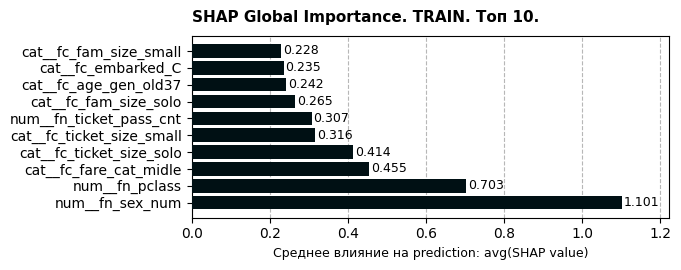

In [35]:
shap_plot(res_train_exploded, 10, "Global Importance. TRAIN.")

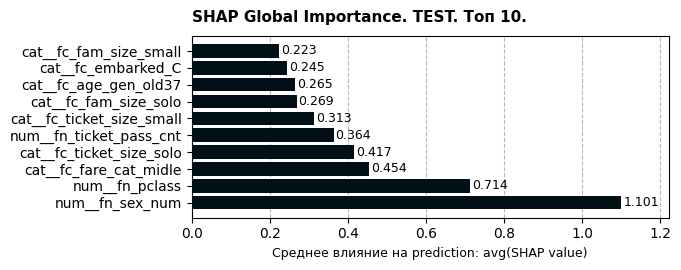

In [36]:
shap_plot(res_test_exploded, 10, "Global Importance. TEST.")

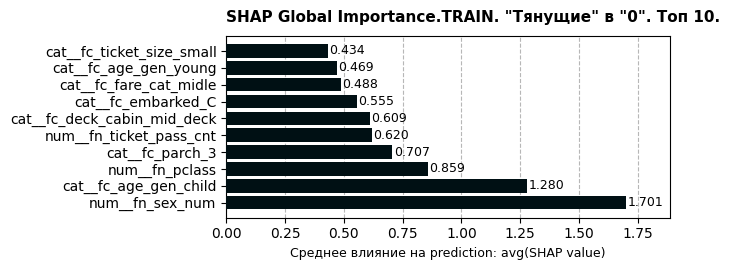

In [37]:
shap_plot(res_train_exploded.where("shap_value >0"), 10, """Global Importance.TRAIN. "Тянущие" в "0".""")

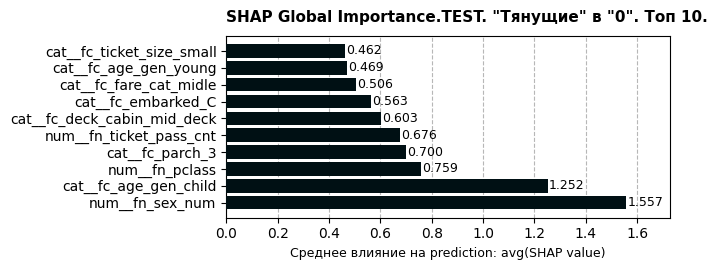

In [38]:
shap_plot(res_test_exploded.where("shap_value >0"), 10, """Global Importance.TEST. "Тянущие" в "0".""")

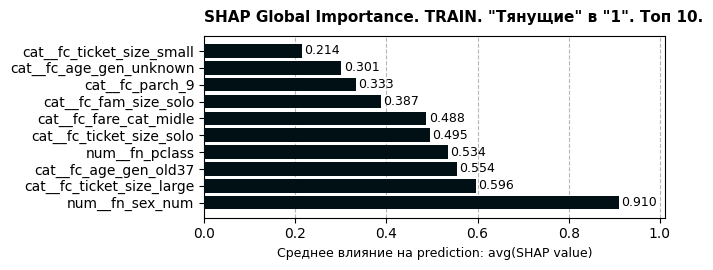

In [39]:
shap_plot(res_train_exploded.where("shap_value <0"), 10, """Global Importance. TRAIN. "Тянущие" в "1".""")

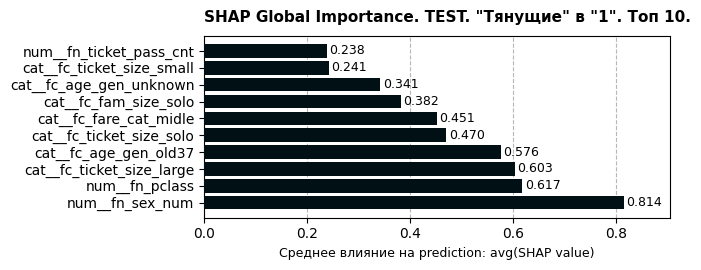

In [40]:
shap_plot(res_test_exploded.where("shap_value <0"), 10, """Global Importance. TEST. "Тянущие" в "1".""")

### Расчет метрик (ACCURACY, PR, F1, ROC AUC, GINI)

**Расчет Confusion метрик + ACCURACY  PRECISION/RECALL и F1**

In [41]:
# Расчет 
df_result_metric = accuracy_precision_recall(df=res_train, info="TRAIN") \
                        .unionByName(accuracy_precision_recall(df=res_test, info = "TEST")).cache()
# Перенос в переменные
result_metric = df_result_metric.collect()

cm_train = []; cm_test = []
for row in result_metric:
    if row["info"] == "TRAIN": cm_train = {"1": np.array([[row["TN"], row["FP"]], [row["FN"], row["TP"]]])} # Обучающая выборка
    if row["info"] == "TEST":  cm_test = {"1":  np.array([[row["TN"], row["FP"]], [row["FN"], row["TP"]]])} # Тестовая выборка 
    
df_result_metric.show()

[Stage 515:==================================================>  (379 + 3) / 400]

+-----+---+---+---+---+------------------+------------------+------------------+------------------+
| info| TP| TN| FP| FN|          ACCURACY|         PRECISION|            RECALL|                F1|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+
|TRAIN|250|507| 77|109|0.8027571580063627| 0.764525993883792|0.6963788300835655|0.7288629737609329|
| TEST|100|196| 29| 41|0.8087431693989071|0.7751937984496124|0.7092198581560284|0.7407407407407407|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+



**Confusion Matrix**

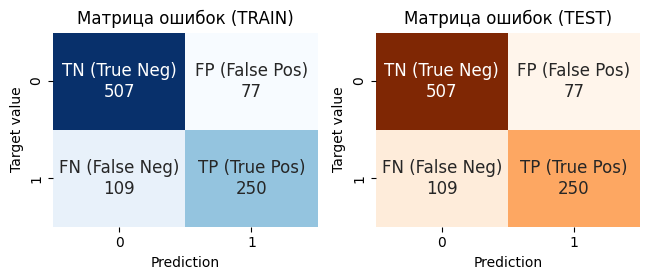

In [42]:
confusion_matrix_plot(cm_train["1"],cm_train["1"])

**Precission-recall curve**

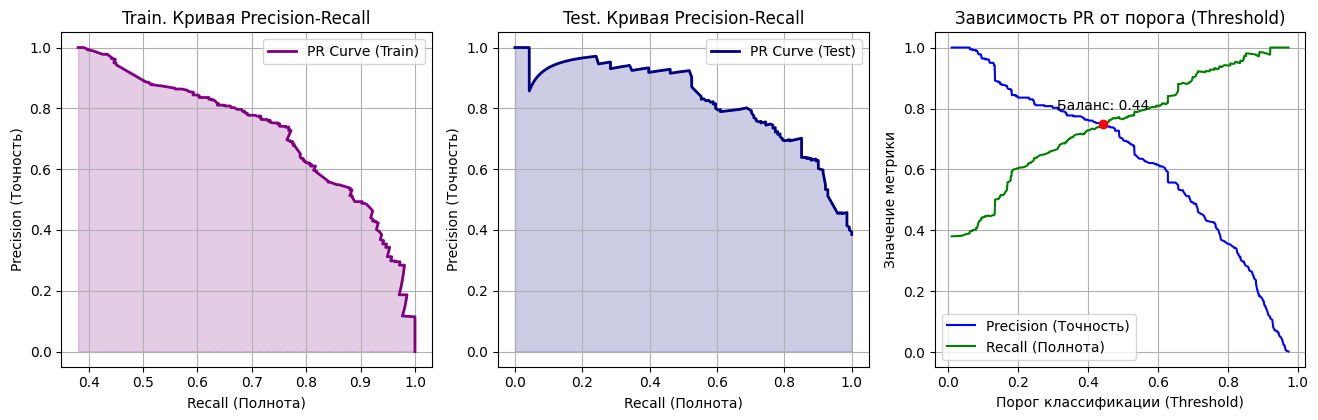

In [43]:
pdf_train = res_train.select( f_.col("label").cast("float"), "probability").toPandas()
pdf_test = res_test.select( f_.col("label").cast("float"), "probability").toPandas()

precission_recall_curve_plot(pdf_train, pdf_test)

**ROC AUC и GINI**

In [44]:
roc_auc_train = evaluator.evaluate(res_train.select("label","probability"))
roc_auc_test  = evaluator.evaluate(res_test.select("label","probability"))

print("train: ROC AUC:",roc_auc_train, "GINI:", 2* roc_auc_train -1)
print("test: ROC AUC:",roc_auc_test, "GINI:", 2* roc_auc_test -1)

train: ROC AUC: 0.8510178578242451 GINI: 0.7020357156484902
test: ROC AUC: 0.8706225374310474 GINI: 0.7412450748620949


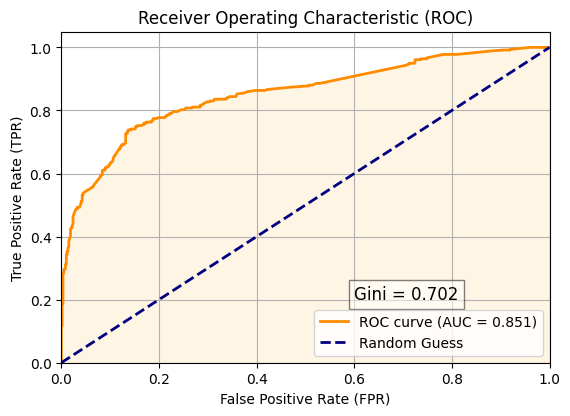

In [45]:
roc_auc_curve_plot(pdf_train)

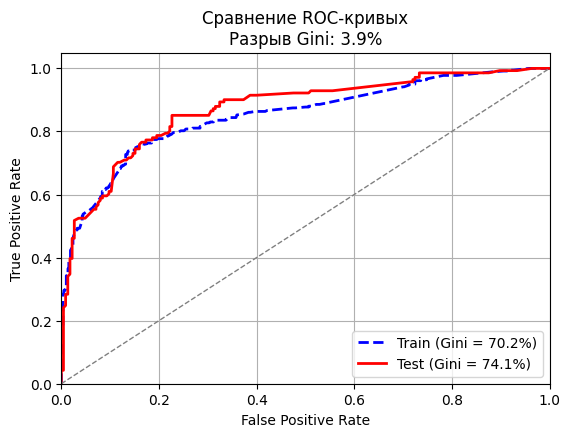

In [46]:
roc_auc_compare_plot(pdf_train, pdf_test)

## Обучение группы моделей (модель на каждую группу)

### Разделение групп fare_per_pers на train и test

**Разбиение DataSet на train и test с учетом группировки по fare_per_pers**  

Группы fare_per_pers:  
 - Below_23_p: < 23 фунтов (дешевый и средний тариф );
 - Above_23_p: >= 23 фунтов (дорогой тариф);
 
Строится 2 модели выживаемости в каждой группе 

In [47]:
titanic_data_w_group = titanic_data.withColumn("model_id",f_.when(f_.col("fare_per_pers")<23.0, f_.lit("Below_23_p")) \
               .otherwise(f_.lit("Above_23_p")))

titanic_data_w_group.groupBy("model_id").count().show()

list_models = [row.model_id for row in titanic_data_w_group.select("model_id").distinct().collect()]

+----------+-----+
|  model_id|count|
+----------+-----+
|Below_23_p|  993|
|Above_23_p|  316|
+----------+-----+



In [48]:
df_with_strata = (titanic_data_w_group
                          .withColumn("strata",f_.concat_ws("_", f_.col("model_id"), f_.col("label").cast("string")))
                  )

test_fraction = 0.3

# одна и та же доля для всех страт
strata_values = [row["strata"] for row in df_with_strata.select("strata").distinct().collect()]
fractions = {s: test_fraction for s in strata_values}

df_models_test = df_with_strata.stat.sampleBy("strata", fractions, seed=42).drop("strata")

df_models_train = df_with_strata.join(df_models_test.select("uid"), on="uid", how="left_anti").drop("strata")

**Статистика**

In [49]:
for model_id in list_models: 
    print("model_id:", model_id)
    simpleDataStat(full=titanic_data_w_group.where(f"model_id = '{model_id}'")
                  ,train=df_models_train.where(f"model_id = '{model_id}'")
                  ,test=df_models_test.where(f"model_id = '{model_id}'"))

model_id: Below_23_p
Count data: FULL:  993 (100.0%) TRAIN: 675 (67.98%) TEST: 318 (32.02%)
+-----+----+----+-----+
|label|full|test|train|
+-----+----+----+-----+
|    1| 303| 108|  195|
|    0| 690| 210|  480|
+-----+----+----+-----+

model_id: Above_23_p
Count data: FULL:  316 (100.0%) TRAIN: 215 (68.04%) TEST: 101 (31.96%)
+-----+----+----+-----+
|label|full|test|train|
+-----+----+----+-----+
|    1| 197|  57|  140|
|    0| 119|  44|   75|
+-----+----+----+-----+



### Отобранные фичи для обучения

In [50]:
# Фичи
num_ftrs = ["age", "sibsp", "parch", "sex_num"] # Числовые фичи
cat_ftrs = ["embarked", "title_name", "age_gen", "fam_size", "deck_cabin"] # Категориальные фичи

features = [f_.col(i).alias("fn_" + i) for i in num_ftrs] \
         + [f_.col(i).alias("fc_" + i) for i in cat_ftrs] 
# DataDrame для обучения
models_train = df_models_train.select(*features , "label", "uid", "model_id")
models_test  = df_models_test.select(*features , "label", "uid", "model_id")

### Тренировка модели

In [51]:
# Train
modelsdf = (models_train.groupBy("model_id")      # по группам fare_per_pers
                        .applyInPandas(train_model, schema=modelschema)).cache()
# modeldf содержит строку с бинарной моделью
modelsdf.show(vertical = True, truncate=80)

-RECORD 0---------------------------------------------------------------------------------------
 model_id    | Below_23_p                                                                       
 model_bytes | [80 04 95 E5 0B 00 00 00 00 00 00 8C 10 73 6B 6C 65 61 72 6E 2E 70 69 70 65 6... 
 bias        | 0.6028230781749585                                                               
 coefs       | {num__fn_age -> -0.0036844181245365777, num__fn_sibsp -> -0.5651826351421533,... 
-RECORD 1---------------------------------------------------------------------------------------
 model_id    | Above_23_p                                                                       
 model_bytes | [80 04 95 E5 0B 00 00 00 00 00 00 8C 10 73 6B 6C 65 61 72 6E 2E 70 69 70 65 6... 
 bias        | 1.0156378930349432                                                               
 coefs       | {num__fn_age -> -0.012615384477374366, num__fn_sibsp -> 0.5320923075011714, n... 



In [52]:
print("Коэффициенты")
modelsdf.select("model_id","bias",f_.explode("coefs")) \
        .withColumnRenamed("key","feature") \
        .withColumnRenamed("value","coefficient") \
        .orderBy("model_id") \
        .show(7, truncate = False)

Коэффициенты
+----------+------------------+------------------+---------------------+
|model_id  |bias              |feature           |coefficient          |
+----------+------------------+------------------+---------------------+
|Above_23_p|1.0156378930349432|num__fn_age       |-0.012615384477374366|
|Above_23_p|1.0156378930349432|num__fn_sibsp     |0.5320923075011714   |
|Above_23_p|1.0156378930349432|num__fn_parch     |-0.035427845678768305|
|Above_23_p|1.0156378930349432|num__fn_sex_num   |-1.352426403318176   |
|Above_23_p|1.0156378930349432|cat__fc_embarked_C|0.9178615368728174   |
|Above_23_p|1.0156378930349432|cat__fc_embarked_Q|0.03944827091712674  |
|Above_23_p|1.0156378930349432|cat__fc_embarked_S|0.05832808524500834  |
+----------+------------------+------------------+---------------------+
only showing top 7 rows



### Применение модели  к train и tset

**Применение модели к train DataSet через applyInPandas**

In [53]:
res_trains, res_trains_exploded = inference(models_train, modelsdf ,model_id=f_.col("model_id"))

In [54]:
res_tests, res_tests_exploded = inference(models_test, modelsdf ,model_id=f_.col("model_id"))

In [55]:
res_trains.show(1, vertical=True)

-RECORD 0-----------------------------
 uid           | 29                   
 probability   | 0.4041535595285864   
 prediction    | 0                    
 features      | {num__fn_age -> [... 
 model_id      | Above_23_p           
 fn_age        | 28.0                 
 fn_sibsp      | 0                    
 fn_parch      | 0                    
 fn_sex_num    | 1.0                  
 fc_embarked   | S                    
 fc_title_name | Mr                   
 fc_age_gen    | adult                
 fc_fam_size   | solo                 
 fc_deck_cabin | other_deck           
 label         | 1                    
 model_bytes   | [80 04 95 E5 0B 0... 
 bias          | 1.0156378930349432   
 coefs         | {num__fn_age -> -... 
only showing top 1 row



## Расчет метрик группы моделей

### PSI test к train  
**Границы:** 

- PSI < 0.1 – стабильно;
- 0.1 ≤ PSI < 0.25 – умеренный сдвиг
- PSI ≥ 0.25 – сильный сдвиг, требуется разбор причин.

In [56]:
psi_udf, schema = create_psi(bins = 4)

In [57]:
psi_results = [
    res_trains_exploded.where(f"model_id = '{i}'") \
                       .groupBy("uid").pivot("feature_nm") \
                       .max("feature_value").withColumn("period_no", f_.lit("0")) \
.unionByName(        
    res_tests_exploded.where(f"model_id = '{i}'") \
                     .groupBy("uid").pivot("feature_nm") \
                     .max("feature_value").withColumn("period_no", f_.lit("1"))
            ).drop("uid") \
             .groupBy() \
             .applyInPandas(psi_udf, schema=schema).cache()    

    for i in list_models]

**Модель "Below_23_p"**

In [58]:
psi_results[0].groupby(f_.when(f_.col("psi")<0.1,  f_.lit("< 0.1")) \
                .when(f_.col("psi")<0.25, f_.lit("< 0.25")) \
                .otherwise(f_.lit("≥ 0.25")).alias("psi_edge") 
    ).agg(f_.count("*").alias("count"), f_.max("psi").alias("max")) \
     .show(5, truncate = False)

+--------+-----+-------------------+
|psi_edge|count|max                |
+--------+-----+-------------------+
|< 0.1   |23   |0.04209807189870489|
+--------+-----+-------------------+



In [59]:
psi_results[0].orderBy(f_.col("psi").desc()).show(5, truncate = False)

+---------+-----------------------+--------------------+
|period_no|feature                |psi                 |
+---------+-----------------------+--------------------+
|1        |cat__fc_title_name_Mr  |0.04209807189870489 |
|1        |cat__fc_title_name_Miss|0.03503049707166743 |
|1        |num__fn_sex_num        |0.030649303045358428|
|1        |num__fn_parch          |0.028891233378247765|
|1        |num__fn_sibsp          |0.028289270013954683|
+---------+-----------------------+--------------------+
only showing top 5 rows



**Модель "Above_23_p"**

In [60]:
psi_results[1].groupby(f_.when(f_.col("psi")<0.1,  f_.lit("< 0.1")) \
              .when(f_.col("psi")<0.25, f_.lit("< 0.25")) \
              .otherwise(f_.lit("≥ 0.25")).alias("psi_edge") 
                       ).agg(f_.count("*").alias("count"), f_.max("psi").alias("max")) \
              .show(5, truncate = False)

+--------+-----+--------------------+
|psi_edge|count|max                 |
+--------+-----+--------------------+
|< 0.1   |22   |0.035882528215191695|
|< 0.25  |1    |0.23459579609920803 |
+--------+-----+--------------------+



In [61]:
psi_results[1].orderBy(f_.col("psi").desc()).show(5, truncate = False)

+---------+-------------------------+--------------------+
|period_no|feature                  |psi                 |
+---------+-------------------------+--------------------+
|1        |cat__fc_title_name_Master|0.23459579609920803 |
|1        |num__fn_age              |0.035882528215191695|
|1        |cat__fc_age_gen_unknown  |0.03311086659493881 |
|1        |cat__fc_age_gen_old37    |0.024917428087442343|
|1        |cat__fc_embarked_Q       |0.022181627375239543|
+---------+-------------------------+--------------------+
only showing top 5 rows



### SHAP Values

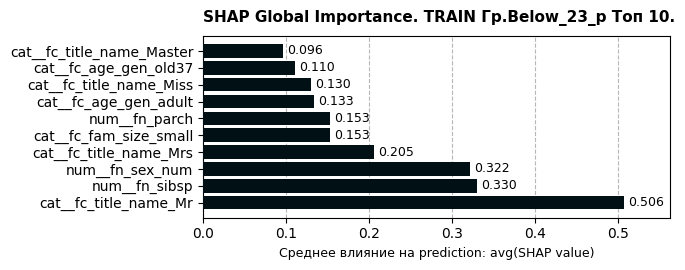

In [62]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[0]}'"), 10, f"Global Importance. TRAIN Гр.{list_models[0]}")

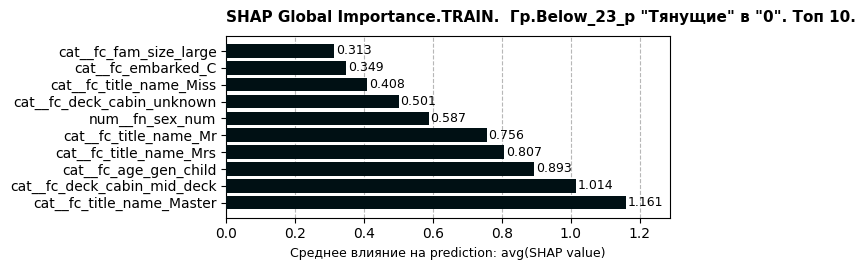

In [63]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[0]}'") \
                             .where("shap_value >0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[0]} "Тянущие" в "0".""")

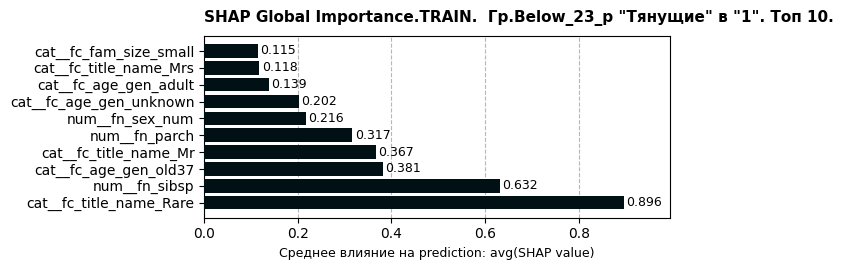

In [64]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[0]}'") \
                             .where("shap_value <0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[0]} "Тянущие" в "1".""")

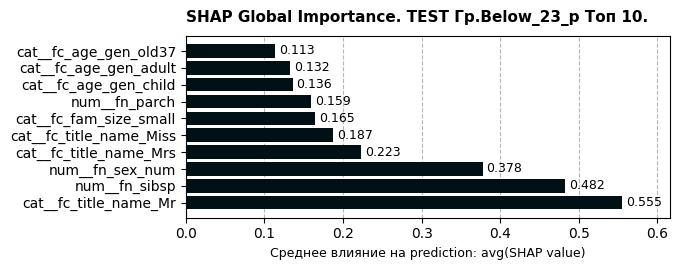

In [65]:
shap_plot(res_tests_exploded.where(f"model_id = '{list_models[0]}'"), 10, f"Global Importance. TEST Гр.{list_models[0]}")

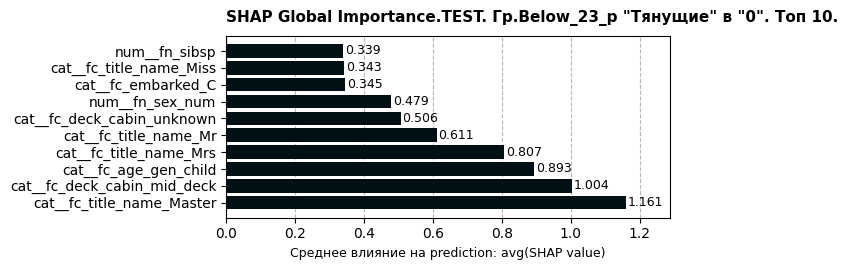

In [66]:
shap_plot(res_tests_exploded.where(f"model_id = '{list_models[0]}'") \
                            .where("shap_value >0"), 10, f"""Global Importance.TEST. Гр.{list_models[0]} "Тянущие" в "0".""")

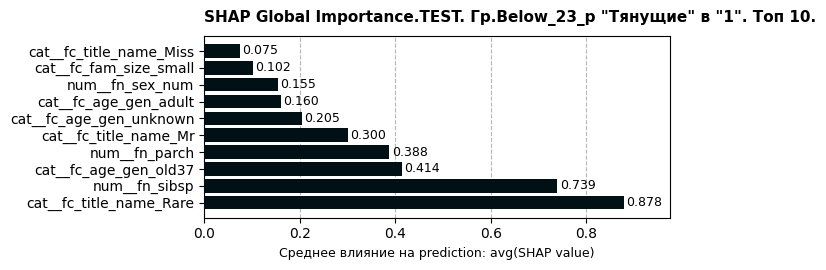

In [67]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[0]}'") \
                              .where("shap_value <0"), 10, f"""Global Importance.TEST. Гр.{list_models[0]} "Тянущие" в "1".""")

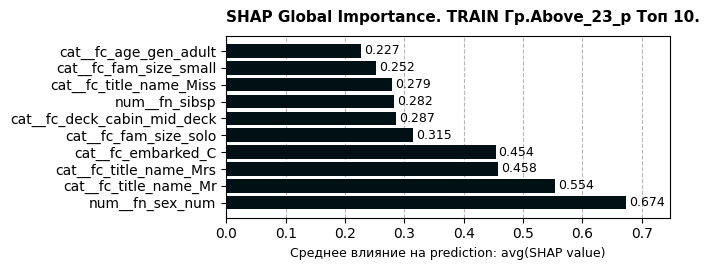

In [68]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[1]}'"), 10, f"Global Importance. TRAIN Гр.{list_models[1]}")

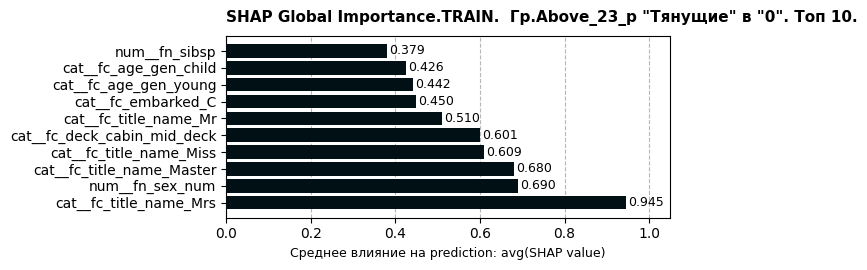

In [69]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[1]}'") \
                             .where("shap_value >0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[1]} "Тянущие" в "0".""")

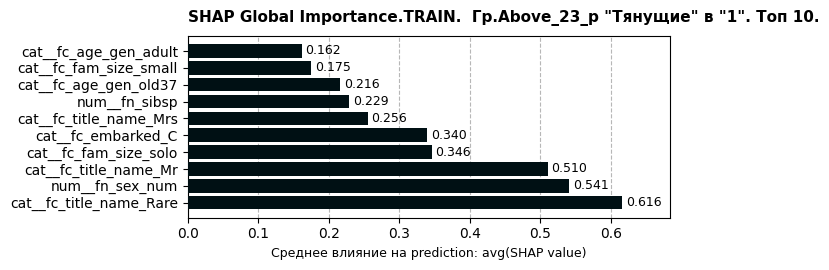

In [70]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[1]}'") \
                             .where("shap_value <0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[1]} "Тянущие" в "1".""")

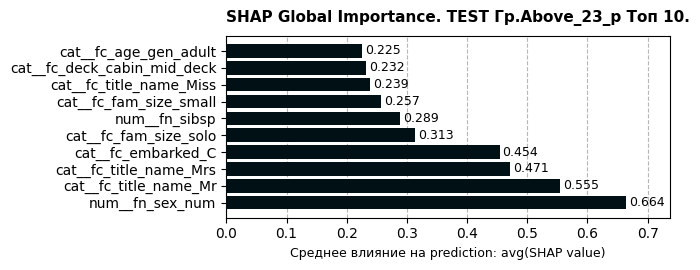

In [71]:
shap_plot(res_tests_exploded.where(f"model_id = '{list_models[1]}'"), 10, f"Global Importance. TEST Гр.{list_models[1]}")

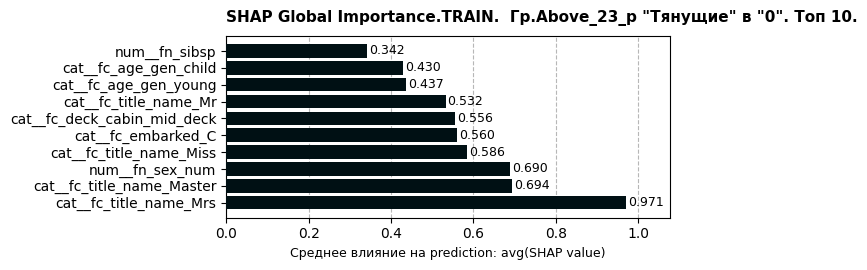

In [72]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[1]}'") \
                             .where("shap_value >0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[1]} "Тянущие" в "0".""")

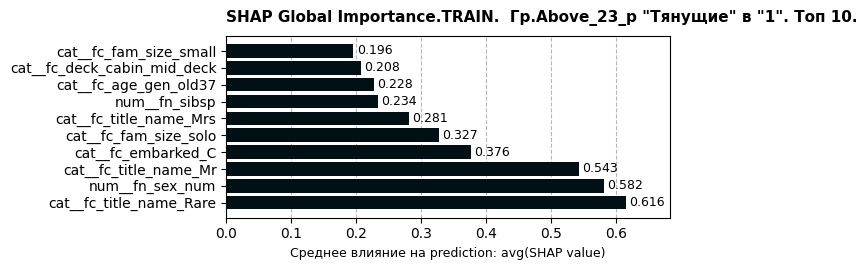

In [73]:
shap_plot(res_trains_exploded.where(f"model_id = '{list_models[1]}'") \
                             .where("shap_value <0"), 10, f"""Global Importance.TRAIN.  Гр.{list_models[1]} "Тянущие" в "1".""")

### Расчет метрик (ACCURACY, PR, F1, ROC AUC, GINI)

**Расчет Confusion метрик + ACCURACY  PRECISION/RECALL и F1**

In [74]:
cm_train = {}; cm_test = {}
for model_id in list_models:
    print("model_id:", model_id)
    df_result_metric = accuracy_precision_recall(df=res_trains.where(f"model_id = '{model_id}'"), info="TRAIN")\
                .unionByName(accuracy_precision_recall(df=res_tests.where(f"model_id = '{model_id}'"),info = "TEST")).cache()

    # Перенос в переменные
    result_metric = df_result_metric.collect()

    for row in result_metric:
        if row["info"] == "TRAIN": cm_train.update({model_id: np.array([[row["TN"], row["FP"]], [row["FN"], row["TP"]]])}) # Обучающая выборка
        if row["info"] == "TEST":  cm_test.update({model_id:  np.array([[row["TN"], row["FP"]], [row["FN"], row["TP"]]])}) # Тестовая выборка 

    df_result_metric.show()

model_id: Below_23_p


+-----+---+---+---+---+------------------+------------------+------------------+------------------+
| info| TP| TN| FP| FN|          ACCURACY|         PRECISION|            RECALL|                F1|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+
|TRAIN|131|423| 57| 64|0.8207407407407408|0.6968085106382979|0.6717948717948717|0.6840731070496083|
| TEST| 77|175| 35| 31|0.7924528301886793|            0.6875|0.7129629629629629|               0.7|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+

model_id: Above_23_p


+-----+---+---+---+---+------------------+------------------+------------------+------------------+
| info| TP| TN| FP| FN|          ACCURACY|         PRECISION|            RECALL|                F1|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+
|TRAIN|118| 63| 12| 22|0.8418604651162791|0.9076923076923077|0.8428571428571429|0.8740740740740741|
| TEST| 45| 28| 16| 12|0.7227722772277227|0.7377049180327869|0.7894736842105263|0.7627118644067796|
+-----+---+---+---+---+------------------+------------------+------------------+------------------+



**Confusion Matrix Below_23_p**

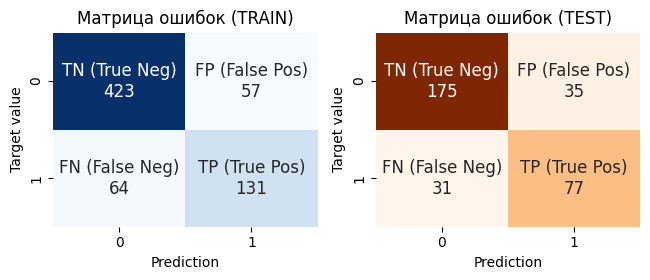

In [75]:
confusion_matrix_plot(cm_train["Below_23_p"],cm_test["Below_23_p"])

**Confusion Matrix Above_23_p**

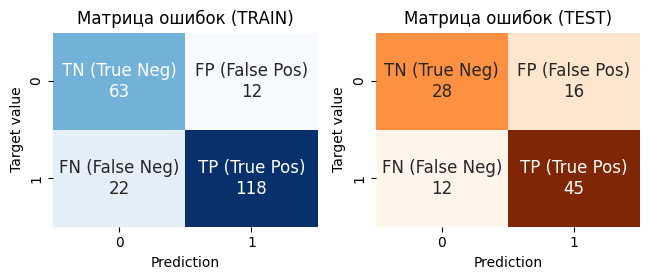

In [76]:
confusion_matrix_plot(cm_train["Above_23_p"],cm_test["Above_23_p"])

**Precission-recall curve Below_23_p**

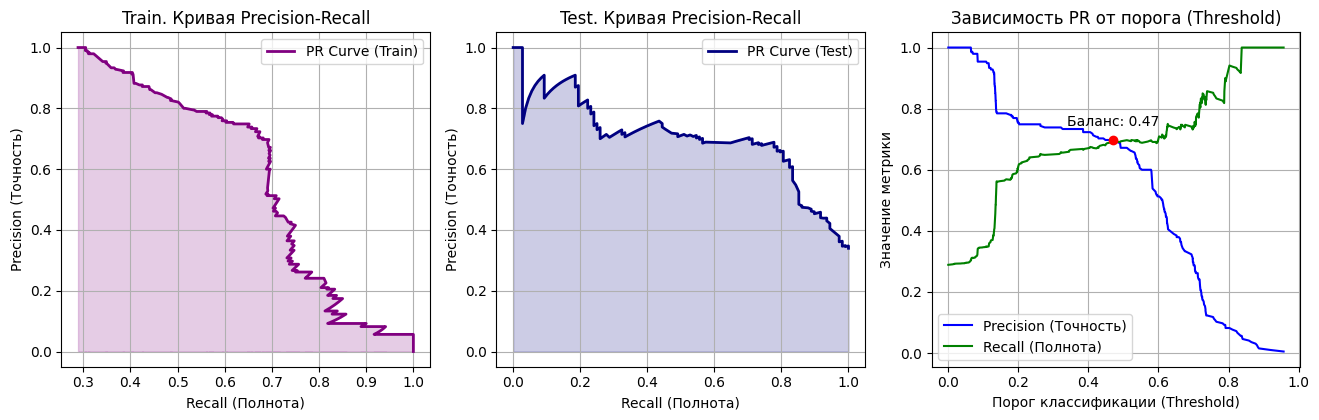

In [77]:
pdf_train = res_trains.where("model_id ='Below_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()
pdf_test = res_tests.where("model_id ='Below_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()

precission_recall_curve_plot(pdf_train, pdf_test)

**Precission-recall curve Above_23_p**

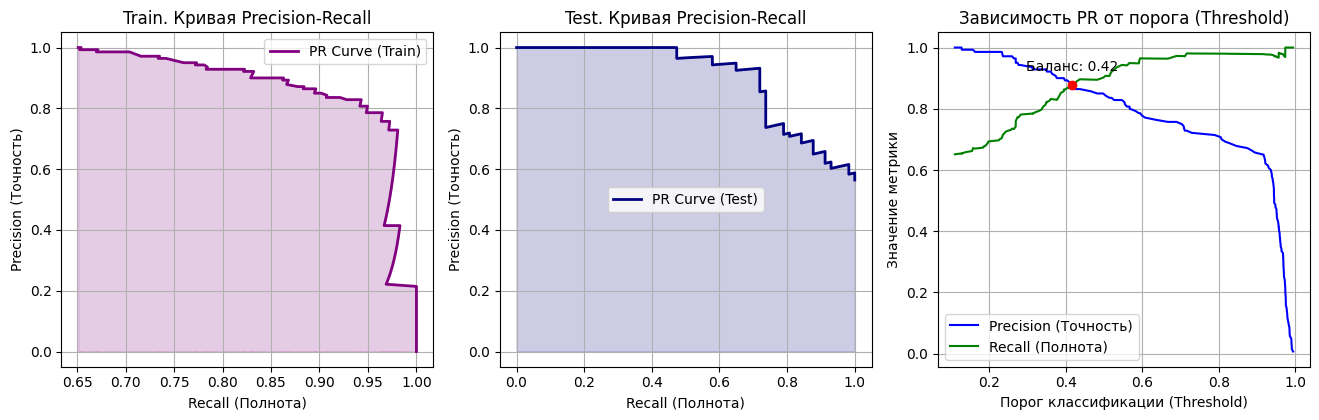

In [78]:
pdf_train = res_trains.where("model_id ='Above_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()
pdf_test = res_tests.where("model_id ='Above_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()

precission_recall_curve_plot(pdf_train, pdf_test)

In [79]:
for model_id in list_models:
    predictions_train = res_trains.where(f"model_id = '{model_id}'").select("label","probability")
    predictions_test = res_tests.where(f"model_id = '{model_id}'").select("label","probability")

    roc_auc_train = evaluator.evaluate(predictions_train)
    roc_auc_test = evaluator.evaluate(predictions_test)
    print(f"model_id = {model_id}")
    print(f"train: ROC AUC: {roc_auc_train}", "GINI:", 2* roc_auc_train -1)
    print(f"test:  ROC AUC:",roc_auc_test,  "GINI:", 2* roc_auc_test -1)

model_id = Below_23_p
train: ROC AUC: 0.8287232905982915 GINI: 0.6574465811965831
test:  ROC AUC: 0.8205687830687838 GINI: 0.6411375661375676
model_id = Above_23_p
train: ROC AUC: 0.9099047619047617 GINI: 0.8198095238095233
test:  ROC AUC: 0.8369218500797446 GINI: 0.6738437001594892


**Below_23_p. roc_curve, auc**

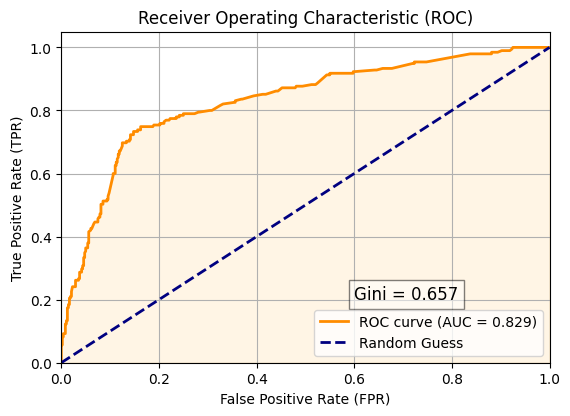

In [80]:
pdf_train = res_trains.where("model_id ='Below_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()
pdf_test = res_tests.where("model_id ='Below_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()

roc_auc_curve_plot(pdf_train)

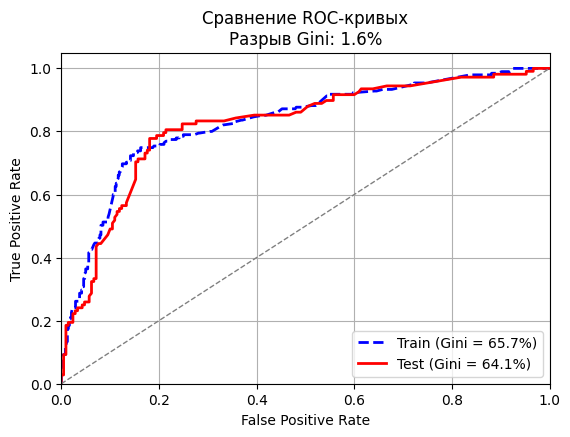

In [81]:
roc_auc_compare_plot(pdf_train, pdf_test)

**Above_23_p. roc_curve, auc**

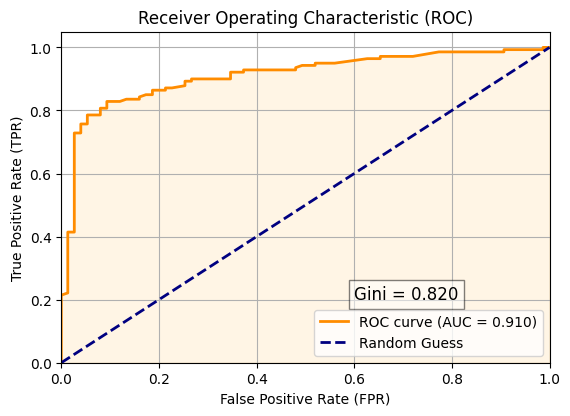

In [82]:
pdf_train = res_trains.where("model_id ='Above_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()
pdf_test = res_tests.where("model_id ='Above_23_p'").select( f_.col("label").cast("float"), "probability").toPandas()

roc_auc_curve_plot(pdf_train)

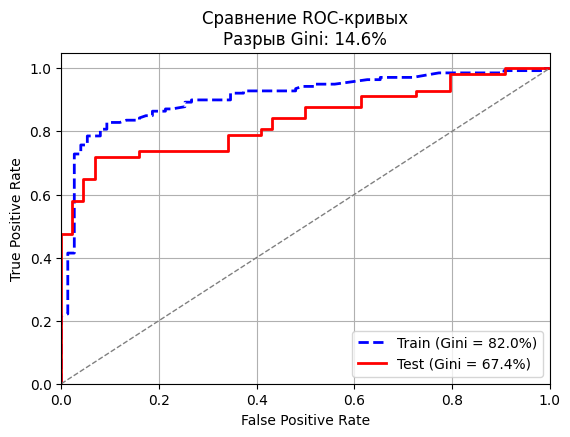

In [83]:
roc_auc_compare_plot(pdf_train, pdf_test)

# Stop Spark Session

In [84]:
spark.stop()